In [5]:
# === Build buckets by sourcing_type (keep only selected types) ===
# Buckets: Proprietary, Limited Auction, Broad Auction
from pathlib import Path
import pandas as pd
import numpy as np

# ---- helper ----
def find_upwards(rel_path: Path, max_up: int = 8) -> Path:
    here = Path.cwd()
    for parent in [here, *here.parents][: max_up + 1]:
        p = parent / rel_path
        if p.exists():
            return p.resolve()
    raise FileNotFoundError(f"Couldn't locate '{rel_path.as_posix()}' from {here} by walking up {max_up} levels.")

# ---- paths ----
TARGET_CSV = (find_upwards(Path("ValueCreation")) / "Data" / "working.csv")
OUT_DIR    = (find_upwards(Path("ValueCreation")) / "ValueCreationBreakdown" / "03BySourcingType")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV    = OUT_DIR / "sourcing_type.csv"

# ---- load + guards ----
df = pd.read_csv(TARGET_CSV, dtype={"id": str, "deal_id": str})
assert df.groupby("deal_id")["id"].nunique().eq(2).all(), "Expected exactly 2 rows per deal_id."

# ---- identify entry row and take sourcing_type there ----
df["_rank"] = df.groupby("deal_id")["reference_date"].transform(
    lambda s: pd.to_datetime(s, errors="coerce")
).groupby(df["deal_id"]).rank(method="first", ascending=True)

entry = df.loc[df["_rank"] == 1, ["deal_id", "sourcing_type"]].copy()

# ---- restrict to desired types; drop all others ----
keep_types = ["Proprietary", "Limited Auction", "Broad Auction"]
entry_clean = (
    entry.dropna(subset=["sourcing_type"])
         .loc[entry["sourcing_type"].isin(keep_types)]
         .copy()
)

# ---- attach bucket to all rows of each deal and keep only selected ----
bucket_map = entry_clean.set_index("deal_id")["sourcing_type"].to_dict()

out = df.copy()
out["sourcing_bucket"] = out["deal_id"].map(bucket_map)
out = out[out["sourcing_bucket"].isin(keep_types)].copy()

# ---- persist ----
out.to_csv(OUT_CSV, index=False)

# ---- counts ----
counts = (entry_clean.groupby("sourcing_type")["deal_id"].nunique()
          .reindex(keep_types, fill_value=0))
print(f"Wrote: {OUT_CSV}")
print("Deal counts per sourcing bucket:", counts.to_dict())
dropped = df["deal_id"].nunique() - out["deal_id"].nunique()
print(f"Dropped deals (other/missing sourcing_type): {dropped}")


Wrote: /Users/michael/Library/Mobile Documents/com~apple~CloudDocs/Studium TUM/Master Management and Technology/06 Master Thesis/00 Thesis/05Code/ValueCreation/ValueCreationBreakdown/03BySourcingType/sourcing_type.csv
Deal counts per sourcing bucket: {'Proprietary': 91, 'Limited Auction': 23, 'Broad Auction': 35}
Dropped deals (other/missing sourcing_type): 29


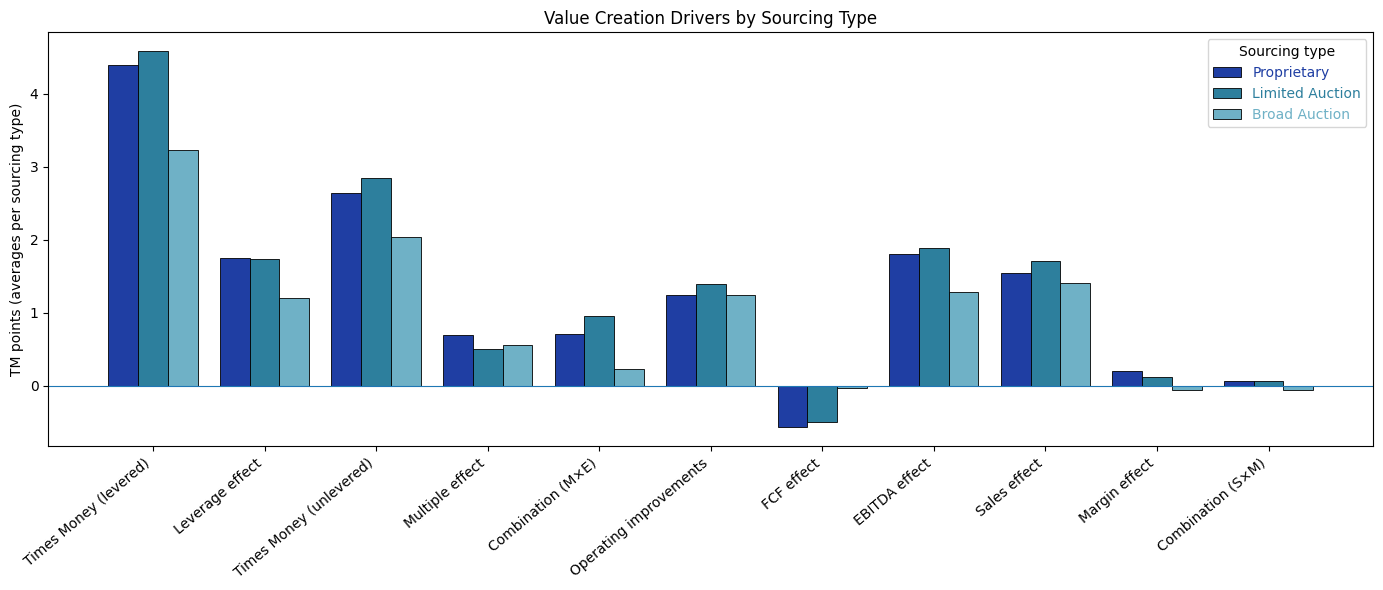

Deal counts per sourcing type: {'Proprietary': 91, 'Limited Auction': 23, 'Broad Auction': 35}

TM-point averages per component × sourcing type:
sourcing_bucket          Proprietary  Limited Auction  Broad Auction
Times Money (levered)          4.388            4.584          3.235
Leverage effect                1.744            1.733          1.203
Times Money (unlevered)        2.645            2.851          2.032
Multiple effect                0.694            0.508          0.554
Combination (M×E)              0.711            0.953          0.231
Operating improvements         1.239            1.390          1.247
FCF effect                    -0.572           -0.502         -0.036
EBITDA effect                  1.811            1.891          1.284
Sales effect                   1.547            1.708          1.402
Margin effect                  0.201            0.117         -0.052
Combination (S×M)              0.063            0.067         -0.066


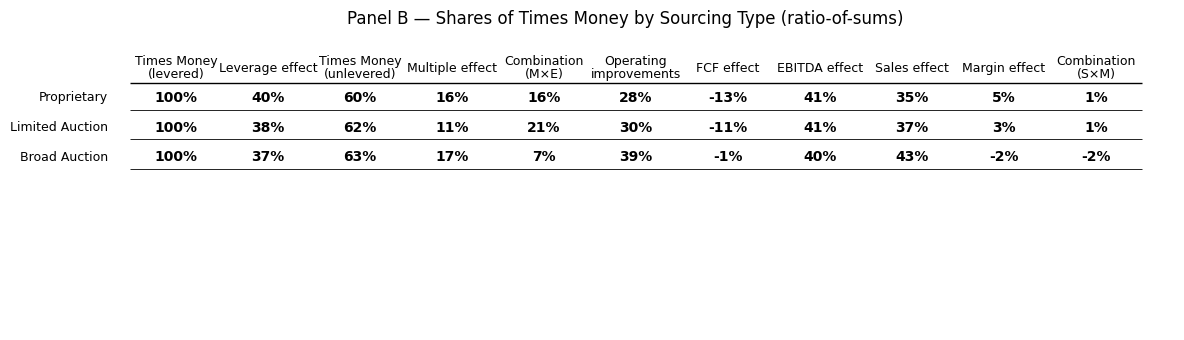

In [6]:
# === Value Creation by Sourcing Type — clustered bars + Panel B table-style ===
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap

# ---------- paths ----------
def find_upwards(rel_path: Path, max_up: int = 8) -> Path:
    here = Path.cwd()
    for parent in [here, *here.parents][: max_up + 1]:
        p = parent / rel_path
        if p.exists():
            return p.resolve()
    raise FileNotFoundError(f"Couldn't locate '{rel_path.as_posix()}' from {here} by walking up {max_up} levels.")

BASE     = find_upwards(Path("ValueCreation"))
WORK_CSV = (BASE / "Data" / "working.csv")
SRC_CSV  = (BASE / "ValueCreationBreakdown" / "03BySourcingType" / "sourcing_type.csv")

# ---------- load ----------
work = pd.read_csv(WORK_CSV, dtype={"deal_id": str})
src  = pd.read_csv(SRC_CSV, dtype={"deal_id": str})

# ---------- deal-view (1 row per deal) + join buckets ----------
NUMERIC_COLS = [
    "times_money","leverage_effect","tm_unlevered",
    "tmu_contrib_multiple_effect",
    "tmu_contrib_multiple_ebitda_combination_effect",
    "tmu_contrib_fcf_effect",
    "tmu_contrib_ebitda_effect",
    "tmu_contrib_sales_effect",
    "tmu_contrib_margin_effect",
    "tmu_contrib_sales_margin_combination_effect",
]
need = ["deal_id","sourcing_bucket"] + NUMERIC_COLS

deal_metrics = work.groupby("deal_id", as_index=False)[NUMERIC_COLS].first()
deal_buckets = src.groupby("deal_id", as_index=False)[["sourcing_bucket"]].first()
deal = deal_metrics.merge(deal_buckets, on="deal_id", how="inner")[need]

# order across the sourcing spectrum (edit if you prefer alphabetical)
bucket_order = ["Proprietary", "Limited Auction", "Broad Auction"]
deal = deal[deal["sourcing_bucket"].isin(bucket_order)].copy()

# ---------- Panel A-style means (TM points) ----------
grp = deal.groupby("sourcing_bucket")
means = pd.DataFrame({
    "Times Money (levered)"  : grp["times_money"].mean(),
    "Leverage effect"        : grp["leverage_effect"].mean(),
    "Times Money (unlevered)": grp["tm_unlevered"].mean(),
    "Multiple effect"        : grp["tmu_contrib_multiple_effect"].mean(),
    "Combination (M×E)"      : grp["tmu_contrib_multiple_ebitda_combination_effect"].mean(),
    "Operating improvements" : grp["tmu_contrib_fcf_effect"].mean() + grp["tmu_contrib_ebitda_effect"].mean(),
    "FCF effect"             : grp["tmu_contrib_fcf_effect"].mean(),
    "EBITDA effect"          : grp["tmu_contrib_ebitda_effect"].mean(),
    "Sales effect"           : grp["tmu_contrib_sales_effect"].mean(),
    "Margin effect"          : grp["tmu_contrib_margin_effect"].mean(),
    "Combination (S×M)"      : grp["tmu_contrib_sales_margin_combination_effect"].mean(),
}).T
means = means.reindex(columns=bucket_order)

PALETTE = {
    "Proprietary":     "#1f3ea3",  # blue
    "Limited Auction": "#2d7f9d",  # teal/green
    "Broad Auction":   "#6fb1c6",  # lighter shade
}

component_order = [
    "Times Money (levered)",
    "Leverage effect",
    "Times Money (unlevered)",
    "Multiple effect",
    "Combination (M×E)",
    "Operating improvements",
    "FCF effect",
    "EBITDA effect",
    "Sales effect",
    "Margin effect",
    "Combination (S×M)",
]
means = means.reindex(component_order)

# ---------- clustered bars ----------
fig, ax = plt.subplots(figsize=(14, 6))
n_comp   = len(means.index)
n_bucket = len(means.columns)
x        = np.arange(n_comp)
width    = 0.8 / n_bucket

for i, b in enumerate(means.columns):
    ax.bar(
        x + (i - (n_bucket-1)/2) * width,
        means[b].to_numpy(),
        width=width,
        label=b,
        color=PALETTE[b],       # ← add
        edgecolor="black",
        linewidth=0.6
    )

ax.set_xticks(x)
ax.set_xticklabels(means.index, rotation=40, ha="right")
ax.axhline(0, linewidth=0.8)
ax.set_ylabel("TM points (averages per sourcing type)")
ax.set_title("Value Creation Drivers by Sourcing Type")
ax.legend(title="Sourcing type")
leg = ax.legend(title="Sourcing type")
for i, txt in enumerate(leg.get_texts()):
    bucket = means.columns[i]
    txt.set_color(PALETTE[bucket])

fig.tight_layout()
plt.show()

# ---------- table of averages ----------
counts = deal.groupby("sourcing_bucket")["deal_id"].nunique().reindex(bucket_order, fill_value=0)
print("Deal counts per sourcing type:", counts.to_dict())
print("\nTM-point averages per component × sourcing type:")
print(means.round(3).to_string(float_format=lambda x: f"{x:.3f}"))

# ---------- Panel B — table-style (shares of Times Money, ratio-of-sums) ----------
cols_needed = [
    "times_money","leverage_effect",
    "tmu_contrib_multiple_effect",
    "tmu_contrib_multiple_ebitda_combination_effect",
    "tmu_contrib_fcf_effect",
    "tmu_contrib_ebitda_effect",
    "tmu_contrib_sales_effect",
    "tmu_contrib_margin_effect",
    "tmu_contrib_sales_margin_combination_effect",
]
S = deal.groupby("sourcing_bucket")[cols_needed].sum().reindex(bucket_order)
den = S["times_money"].astype(float)
assert np.all(np.abs(den.values) > 1e-12), "Zero total Times Money in at least one bucket."

def pct(col): return (S[col] / den) * 100.0

panelB = pd.DataFrame(index=bucket_order, columns=component_order, dtype=float)
panelB.loc[:, "Times Money (levered)"]   = 100.0
panelB.loc[:, "Leverage effect"]         = pct("leverage_effect")
panelB.loc[:, "Multiple effect"]         = pct("tmu_contrib_multiple_effect")
panelB.loc[:, "Combination (M×E)"]       = pct("tmu_contrib_multiple_ebitda_combination_effect")
panelB.loc[:, "FCF effect"]              = pct("tmu_contrib_fcf_effect")
panelB.loc[:, "EBITDA effect"]           = pct("tmu_contrib_ebitda_effect")
panelB.loc[:, "Sales effect"]            = pct("tmu_contrib_sales_effect")
panelB.loc[:, "Margin effect"]           = pct("tmu_contrib_margin_effect")
panelB.loc[:, "Combination (S×M)"]       = pct("tmu_contrib_sales_margin_combination_effect")
panelB.loc[:, "Operating improvements"]  = panelB["FCF effect"] + panelB["EBITDA effect"]
panelB.loc[:, "Times Money (unlevered)"] = (
    panelB["Multiple effect"] + panelB["Combination (M×E)"] + panelB["Operating improvements"]
)

# --- table-like figure (rows = sourcing types) ---
headers = component_order
rows    = bucket_order

n_cols = len(headers)
n_rows = len(rows)
fig_h  = 3.0 + (n_rows-1) * 0.25
fig, ax = plt.subplots(figsize=(12, fig_h))
ax.set_axis_off()

left_margin, right_margin = 0.05, 0.97
xs = left_margin + (np.arange(n_cols) + 0.5) * (right_margin - left_margin) / n_cols

y_header = 0.88 #0.88
row_start = 0.78 #0.66
row_gap   = 0.1 #0.16
ys = [row_start - i*row_gap for i in range(n_rows)]

wrap_w = 16
for x_pos, hdr in zip(xs, headers):
    ax.text(x_pos, y_header, textwrap.fill(hdr, width=wrap_w),
            ha="center", va="center", fontsize=9, linespacing=1.05, transform=ax.transAxes)

row_label_x = left_margin - 0.02
for y_pos, r in zip(ys, rows):
    ax.text(row_label_x, y_pos, r,
            ha="right", va="center", fontsize=9, transform=ax.transAxes)

for y_pos, r in zip(ys, rows):
    for x_pos, hdr in zip(xs, headers):
        val = panelB.loc[r, hdr]
        ax.text(x_pos, y_pos, f"{val:.0f}%", ha="center", va="center",
                fontsize=10, fontweight="bold", transform=ax.transAxes)

sep_top = (y_header + ys[0]) / 2
ax.hlines([sep_top], xmin=left_margin, xmax=right_margin,
          colors="black", linewidth=1.0, transform=ax.transAxes)
for y_pos in ys:
    ax.hlines([y_pos - row_gap/2 + 0.01], xmin=left_margin, xmax=right_margin,
              colors="black", linewidth=0.6, transform=ax.transAxes)

ax.set_title("Panel B — Shares of Times Money by Sourcing Type (ratio-of-sums)", pad=6)
fig.tight_layout()
plt.show()
